### 🔧 Installing Required Packages

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.1/922.1 kB 33.8 MB/s eta 0:00:00


### 🧠 Defining the Channel & Spatial Attention (CBAM)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        return x * self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return x * self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

In [3]:
class CBAMConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(CBAMConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.1, inplace=True)
        self.cbam = CBAM(out_channels)  # Ajout de CBAM
    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        x = self.cbam(x)  # Appliquer CBAM après la convolution
        return x

### 🛠️ Customizing the YOLO Backbone

In [4]:
class ModifiedYOLOBackbone(nn.Module):
    def __init__(self):
        super(ModifiedYOLOBackbone, self).__init__()
        self.layer1 = CBAMConv(3, 64, kernel_size=3, stride=1, padding=1)
        self.layer2 = CBAMConv(64, 128, kernel_size=3, stride=2, padding=1)
        self.layer3 = CBAMConv(128, 256, kernel_size=3, stride=2, padding=1)
        self.layer4 = CBAMConv(256, 512, kernel_size=3, stride=2, padding=1)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

### 💾 Saving the New Model

In [5]:
from ultralytics import YOLO
# Load YOLOv8 X model
model = YOLO('yolov8n.pt')  # Ensure you have the weights downloaded
# Remplacer le backbone par le modèle modifié
model.model.backbone = ModifiedYOLOBackbone()
# Sauvegarder le modèle mis à jour
model.save("yolo8n_cbam.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 196MB/s]


In [6]:
from pathlib import Path
import os

path_to_check = "/kaggle/input/pulmonary-nodule-detection/train/anno"
if os.path.isdir(path_to_check):
    print("Le dossier 'data/anno' existe.")
else:
    print("no")

Le dossier 'data/anno' existe.


### 🔄 Converting Annotation Formats


In [7]:
import os
import xml.etree.ElementTree as ET
import random
import shutil
import numpy as np
import cv2
import albumentations as A
from ultralytics import YOLO
from sklearn.metrics import f1_score
from pathlib import Path

classes = ["nodule"]

# Convert XML annotations to YOLO format
def convert_annotation(xml_file, output_dir):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    image_width = int(root.find("size/width").text)
    image_height = int(root.find("size/height").text)
    
    label_file = os.path.join(output_dir, os.path.basename(xml_file).replace(".xml", ".txt"))
    with open(label_file, "w") as f:
        for obj in root.findall("object"):
            class_name = obj.find("name").text
            if class_name not in classes:
                continue
            class_id = classes.index(class_name)
            
            bbox = obj.find("bndbox")
            xmin = round(float(bbox.find("xmin").text))
            ymin = round(float(bbox.find("ymin").text))
            xmax = round(float(bbox.find("xmax").text))
            ymax = round(float(bbox.find("ymax").text))
            
            # Convert to YOLO format
            x_center = (xmin + xmax) / 2 / image_width
            y_center = (ymin + ymax) / 2 / image_height
            bbox_width = (xmax - xmin) / image_width
            bbox_height = (ymax - ymin) / image_height
            
            f.write(f"{class_id} {x_center} {y_center} {bbox_width} {bbox_height}\n")

# Paths for dataset directories
# dataset_path = '/kaggle/input/train/'
annotations_path = "/kaggle/input/pulmonary-nodule-detection/train/anno"
images_path = "/kaggle/input/pulmonary-nodule-detection/train/jpg"
labels_output_path = "dataset/labels"
os.makedirs(labels_output_path, exist_ok=True)

# Convert all annotations to YOLO format
for xml_file in os.listdir(annotations_path):
    if xml_file.endswith(".xml"):
        convert_annotation(os.path.join(annotations_path, xml_file), labels_output_path)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### 📊 Data Splitting (Train / Validation / Test)


In [8]:
# Split dataset
def split_dataset(images_path, labels_path, train_ratio=0.8, val_ratio=0.1):
    images = sorted(os.listdir(images_path))
    random.shuffle(images)
    train_size = int(len(images) * train_ratio)
    val_size = int(len(images) * val_ratio)

    train_files = images[:train_size]
    val_files = images[train_size:train_size + val_size]
    test_files = images[train_size + val_size:]

    for folder in ["train", "val", "test"]:
        os.makedirs(f"dataset/images/{folder}", exist_ok=True)
        os.makedirs(f"dataset/labels/{folder}", exist_ok=True)
    
    for file, subset in zip([train_files, val_files, test_files], ["train", "val", "test"]):
        for img_file in file:
            shutil.copy(os.path.join(images_path, img_file), f"dataset/images/{subset}/")
            label_file = img_file.replace(".jpg", ".txt")
            shutil.copy(os.path.join(labels_path, label_file), f"dataset/labels/{subset}/")

split_dataset(images_path, labels_output_path)

### ⚙️ Training YAML Configuration


In [9]:
# Training configuration
data_yaml_content = """
train: /kaggle/working/dataset/images/train
val: /kaggle/working/dataset/images/val
test: /kaggle/working/dataset/images/test
nc: 1  # Number of classes
names: ["nodule"]
"""
with open("data.yaml", "w") as f:
    f.write(data_yaml_content)

### 🚀 Model Training


In [10]:
results = model.train(
    data="/kaggle/working/data.yaml",
    epochs=150,
    batch=16,
    imgsz=640,
    degrees=15,
    translate=0.2,
    scale=0.6,
    shear=7,
    flipud=0.5,
    fliplr=0.5,
)

Ultralytics 8.3.81 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

100%|██████████| 755k/755k [00:00<00:00, 50.9MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 140MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/labels/train... 1200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1200/1200 [00:01<00:00, 1007.72it/s]


train: New cache created: /kaggle/working/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/dataset/labels/val... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<00:00, 1271.92it/s]

val: New cache created: /kaggle/working/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      2.17G      2.473      3.207      1.848        108        640: 100%|██████████| 75/75 [00:14<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


                   all        150        609      0.704      0.325      0.454      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      2.06G      1.839      2.187      1.396         90        640: 100%|██████████| 75/75 [00:13<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

                   all        150        609      0.404      0.386      0.311     0.0974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150       2.1G      1.825      1.991      1.413        114        640: 100%|██████████| 75/75 [00:13<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.58it/s]

                   all        150        609      0.501      0.415      0.421      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      2.14G      1.768      1.886      1.371         89        640: 100%|██████████| 75/75 [00:12<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.37it/s]


                   all        150        609      0.585      0.433      0.468      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      2.14G      1.742      1.813      1.359         76        640: 100%|██████████| 75/75 [00:13<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.26it/s]

                   all        150        609      0.616      0.563      0.608      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      2.04G      1.722      1.742      1.341        136        640: 100%|██████████| 75/75 [00:12<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.42it/s]

                   all        150        609       0.57      0.568      0.589      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      2.03G      1.686       1.68      1.338         77        640: 100%|██████████| 75/75 [00:13<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]

                   all        150        609      0.679      0.565      0.651      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      2.12G      1.675      1.658      1.315        103        640: 100%|██████████| 75/75 [00:13<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]

                   all        150        609      0.713      0.583      0.655      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      2.14G      1.683       1.65      1.335         95        640: 100%|██████████| 75/75 [00:13<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]

                   all        150        609      0.656      0.599      0.634      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      2.03G      1.635       1.59      1.307         51        640: 100%|██████████| 75/75 [00:12<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]

                   all        150        609      0.671      0.534      0.614      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      2.03G      1.631       1.59      1.296         99        640: 100%|██████████| 75/75 [00:13<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.60it/s]

                   all        150        609      0.635      0.581      0.603      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      2.24G      1.661      1.591      1.315        163        640: 100%|██████████| 75/75 [00:13<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]

                   all        150        609      0.668      0.626      0.676      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      2.04G      1.622      1.575      1.293         84        640: 100%|██████████| 75/75 [00:13<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]

                   all        150        609      0.616      0.612      0.629      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      2.12G       1.61       1.53      1.291         64        640: 100%|██████████| 75/75 [00:13<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]

                   all        150        609      0.697      0.612      0.646      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      2.09G      1.608      1.502      1.283         86        640: 100%|██████████| 75/75 [00:13<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.51it/s]

                   all        150        609      0.717      0.635      0.704      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      2.16G       1.64      1.532      1.292        118        640: 100%|██████████| 75/75 [00:12<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.56it/s]

                   all        150        609        0.7      0.658      0.728      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      2.06G      1.621      1.499      1.282         82        640: 100%|██████████| 75/75 [00:13<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

                   all        150        609      0.719      0.677      0.714      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      2.03G      1.576      1.445      1.267        101        640: 100%|██████████| 75/75 [00:13<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]

                   all        150        609      0.715      0.708      0.756      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      2.19G      1.602      1.456       1.28        104        640: 100%|██████████| 75/75 [00:12<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.94it/s]

                   all        150        609      0.717      0.627      0.707      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      2.06G      1.599       1.44       1.26         79        640: 100%|██████████| 75/75 [00:13<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]

                   all        150        609      0.726      0.614      0.728      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      2.23G      1.599      1.471      1.258         64        640: 100%|██████████| 75/75 [00:13<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]

                   all        150        609      0.709      0.552       0.61      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      2.03G      1.569      1.454      1.259         67        640: 100%|██████████| 75/75 [00:13<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.55it/s]

                   all        150        609      0.709      0.719      0.784      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      2.13G      1.568      1.434      1.264         67        640: 100%|██████████| 75/75 [00:13<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.29it/s]

                   all        150        609      0.702      0.727      0.768      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      2.17G      1.602      1.433      1.256         82        640: 100%|██████████| 75/75 [00:14<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.60it/s]

                   all        150        609      0.727        0.7      0.769      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      2.12G      1.554      1.396      1.243         96        640: 100%|██████████| 75/75 [00:14<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]

                   all        150        609      0.757      0.644      0.758      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      2.15G       1.55      1.426       1.25         96        640: 100%|██████████| 75/75 [00:14<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.23it/s]

                   all        150        609      0.768      0.596      0.716      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      2.12G      1.555      1.405      1.256         94        640: 100%|██████████| 75/75 [00:13<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.60it/s]

                   all        150        609      0.736       0.67       0.73      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      2.02G      1.528       1.37      1.239        150        640: 100%|██████████| 75/75 [00:14<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.26it/s]

                   all        150        609      0.774      0.673      0.771      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      2.12G      1.528       1.36      1.237         75        640: 100%|██████████| 75/75 [00:14<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]

                   all        150        609      0.767      0.663      0.755      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      2.12G      1.556       1.38      1.241         68        640: 100%|██████████| 75/75 [00:14<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.25it/s]

                   all        150        609      0.724      0.741      0.784      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      2.13G      1.532      1.351       1.24         73        640: 100%|██████████| 75/75 [00:13<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.47it/s]

                   all        150        609      0.727      0.716      0.763      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      2.17G       1.51      1.352      1.215         53        640: 100%|██████████| 75/75 [00:14<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.45it/s]

                   all        150        609       0.74       0.68      0.749      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      2.11G      1.525      1.337       1.24         59        640: 100%|██████████| 75/75 [00:13<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]

                   all        150        609      0.776       0.68      0.775      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      2.13G      1.536      1.331      1.239         88        640: 100%|██████████| 75/75 [00:13<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.43it/s]

                   all        150        609      0.761      0.605      0.716      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      2.09G      1.501      1.323      1.227        117        640: 100%|██████████| 75/75 [00:12<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.62it/s]

                   all        150        609       0.79      0.654      0.766      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      2.05G      1.522       1.32       1.25         81        640: 100%|██████████| 75/75 [00:13<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]

                   all        150        609      0.718      0.626      0.718      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      2.05G      1.549      1.355      1.249         92        640: 100%|██████████| 75/75 [00:13<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]

                   all        150        609      0.744      0.652      0.747      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      2.11G       1.52      1.328      1.238        101        640: 100%|██████████| 75/75 [00:13<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]

                   all        150        609      0.771      0.663      0.776      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      2.11G       1.49       1.34      1.219         59        640: 100%|██████████| 75/75 [00:13<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.30it/s]

                   all        150        609       0.74      0.721      0.775      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      2.18G      1.521      1.323      1.242         63        640: 100%|██████████| 75/75 [00:13<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.89it/s]

                   all        150        609      0.775      0.693      0.802       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      2.05G      1.508      1.317      1.218        105        640: 100%|██████████| 75/75 [00:13<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.27it/s]

                   all        150        609      0.698      0.767      0.793      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150       2.1G      1.491      1.323      1.214         74        640: 100%|██████████| 75/75 [00:13<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]

                   all        150        609      0.748      0.763      0.807      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      2.09G      1.534      1.366      1.232         78        640: 100%|██████████| 75/75 [00:13<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.59it/s]

                   all        150        609      0.742      0.708      0.777      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      2.15G       1.49      1.313      1.217         92        640: 100%|██████████| 75/75 [00:13<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.42it/s]

                   all        150        609      0.788      0.747      0.822      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      2.24G      1.484        1.3      1.219         69        640: 100%|██████████| 75/75 [00:13<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.48it/s]

                   all        150        609      0.721       0.75      0.807      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      2.06G      1.493      1.312      1.226         62        640: 100%|██████████| 75/75 [00:13<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.36it/s]

                   all        150        609      0.721      0.722      0.783      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      2.04G      1.498      1.312      1.235        105        640: 100%|██████████| 75/75 [00:13<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.61it/s]

                   all        150        609      0.763      0.691      0.794      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      2.11G      1.481      1.284      1.202        104        640: 100%|██████████| 75/75 [00:13<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.56it/s]

                   all        150        609      0.716      0.772      0.799      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      2.06G      1.484      1.296      1.216         97        640: 100%|██████████| 75/75 [00:13<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.54it/s]

                   all        150        609       0.74      0.781      0.815      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      2.01G      1.504      1.292      1.231        114        640: 100%|██████████| 75/75 [00:13<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.56it/s]

                   all        150        609      0.757      0.719        0.8      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      2.22G      1.468      1.261      1.216         75        640: 100%|██████████| 75/75 [00:13<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.59it/s]

                   all        150        609      0.771      0.759      0.821      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      2.22G      1.467      1.281      1.213         98        640: 100%|██████████| 75/75 [00:13<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.87it/s]

                   all        150        609      0.744      0.744      0.801      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      2.21G      1.469      1.253      1.195        100        640: 100%|██████████| 75/75 [00:13<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]

                   all        150        609      0.724      0.766      0.811      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      2.05G      1.464      1.233      1.204        101        640: 100%|██████████| 75/75 [00:12<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.63it/s]

                   all        150        609      0.786       0.75      0.828      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      2.13G      1.452      1.245      1.202        113        640: 100%|██████████| 75/75 [00:13<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]

                   all        150        609      0.739      0.771      0.816      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      2.12G      1.452      1.255      1.196         62        640: 100%|██████████| 75/75 [00:13<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.60it/s]

                   all        150        609      0.765       0.75      0.824      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      2.14G      1.438      1.257        1.2         51        640: 100%|██████████| 75/75 [00:13<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]

                   all        150        609       0.79      0.698      0.795      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      2.06G      1.459      1.273      1.192         99        640: 100%|██████████| 75/75 [00:13<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.62it/s]

                   all        150        609      0.758      0.742      0.811      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      2.14G      1.449      1.234      1.192         61        640: 100%|██████████| 75/75 [00:13<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

                   all        150        609      0.792      0.749      0.837      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      2.08G      1.463      1.241      1.199         56        640: 100%|██████████| 75/75 [00:13<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]

                   all        150        609      0.759      0.732      0.824      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      2.16G      1.466      1.234      1.193         81        640: 100%|██████████| 75/75 [00:13<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.91it/s]

                   all        150        609      0.761      0.744      0.816      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      2.21G       1.45      1.212      1.192        108        640: 100%|██████████| 75/75 [00:13<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.41it/s]

                   all        150        609      0.749      0.768      0.824      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      2.28G      1.463      1.211      1.189        105        640: 100%|██████████| 75/75 [00:13<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.58it/s]

                   all        150        609      0.749      0.763      0.827       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      2.02G      1.446      1.242      1.205         95        640: 100%|██████████| 75/75 [00:13<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]

                   all        150        609      0.774      0.732       0.83       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      2.13G      1.443      1.204        1.2         88        640: 100%|██████████| 75/75 [00:13<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.55it/s]

                   all        150        609      0.772      0.785      0.837       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      2.15G      1.451      1.226      1.213        139        640: 100%|██████████| 75/75 [00:13<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]

                   all        150        609      0.801      0.744      0.843      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      2.13G      1.433      1.201      1.198         84        640: 100%|██████████| 75/75 [00:13<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]

                   all        150        609      0.766      0.729      0.821      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      2.17G      1.452      1.214      1.197         54        640: 100%|██████████| 75/75 [00:13<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]

                   all        150        609      0.785        0.7      0.806      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150       2.2G      1.444      1.225      1.191         44        640: 100%|██████████| 75/75 [00:13<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]

                   all        150        609        0.8      0.719       0.83      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      2.14G      1.421      1.196      1.187         74        640: 100%|██████████| 75/75 [00:13<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.62it/s]

                   all        150        609      0.777      0.754      0.842      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      2.03G       1.43      1.212      1.191         71        640: 100%|██████████| 75/75 [00:13<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.48it/s]

                   all        150        609      0.789      0.771      0.844      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      2.02G      1.434      1.197      1.188         68        640: 100%|██████████| 75/75 [00:13<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]

                   all        150        609      0.782      0.772      0.843      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      2.01G      1.444      1.195      1.195         70        640: 100%|██████████| 75/75 [00:13<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]

                   all        150        609      0.785       0.79      0.849      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      2.12G      1.414      1.168       1.19         78        640: 100%|██████████| 75/75 [00:14<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.38it/s]

                   all        150        609      0.798      0.766      0.838      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.02G      1.424      1.199      1.191         78        640: 100%|██████████| 75/75 [00:13<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.63it/s]

                   all        150        609      0.769      0.736      0.814      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      2.21G      1.429      1.216      1.183        113        640: 100%|██████████| 75/75 [00:13<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]

                   all        150        609      0.752      0.791      0.838      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      2.12G      1.405      1.185      1.186         83        640: 100%|██████████| 75/75 [00:13<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]

                   all        150        609      0.805      0.762      0.849        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      2.06G      1.402      1.175      1.194        102        640: 100%|██████████| 75/75 [00:13<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.56it/s]

                   all        150        609      0.813      0.732      0.844      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      2.03G      1.428      1.174      1.183         75        640: 100%|██████████| 75/75 [00:13<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]

                   all        150        609       0.78       0.76      0.839      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      2.15G       1.41       1.17      1.183         37        640: 100%|██████████| 75/75 [00:13<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.58it/s]

                   all        150        609      0.773      0.796      0.848      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.07G      1.402      1.151      1.178         76        640: 100%|██████████| 75/75 [00:13<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.56it/s]


                   all        150        609      0.767      0.754       0.84      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      2.06G      1.409      1.158      1.174        111        640: 100%|██████████| 75/75 [00:13<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]

                   all        150        609        0.8      0.759      0.853      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.19G      1.401      1.133      1.157        103        640: 100%|██████████| 75/75 [00:13<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.55it/s]

                   all        150        609      0.785      0.778      0.845      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      2.13G      1.417      1.155      1.187        101        640: 100%|██████████| 75/75 [00:13<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]

                   all        150        609      0.775      0.767      0.831      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.06G      1.392       1.14      1.173         82        640: 100%|██████████| 75/75 [00:13<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.63it/s]

                   all        150        609      0.775      0.774      0.841      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.05G      1.397      1.163      1.175         84        640: 100%|██████████| 75/75 [00:13<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]

                   all        150        609      0.785       0.77      0.843      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.11G        1.4      1.154      1.162         89        640: 100%|██████████| 75/75 [00:13<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]

                   all        150        609      0.799       0.75      0.851      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.16G      1.413      1.157      1.181         98        640: 100%|██████████| 75/75 [00:13<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]

                   all        150        609      0.749      0.759      0.829       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.16G      1.387      1.147      1.179         73        640: 100%|██████████| 75/75 [00:13<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]

                   all        150        609       0.78      0.775      0.846      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      2.03G      1.401      1.145      1.174         95        640: 100%|██████████| 75/75 [00:13<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.25it/s]

                   all        150        609      0.808      0.759      0.853      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.12G      1.401      1.113      1.176        103        640: 100%|██████████| 75/75 [00:14<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]

                   all        150        609      0.759      0.772      0.844      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.03G      1.399      1.171      1.195         80        640: 100%|██████████| 75/75 [00:13<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.47it/s]

                   all        150        609       0.78      0.768      0.851      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.15G      1.385      1.143      1.168         64        640: 100%|██████████| 75/75 [00:13<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]

                   all        150        609      0.763      0.786      0.847      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.12G      1.379      1.128      1.175         78        640: 100%|██████████| 75/75 [00:13<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]

                   all        150        609      0.779      0.778      0.848      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.12G      1.415      1.132      1.188        101        640: 100%|██████████| 75/75 [00:13<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.96it/s]

                   all        150        609      0.778        0.8      0.854       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      2.03G      1.389      1.152      1.186         80        640: 100%|██████████| 75/75 [00:13<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]

                   all        150        609      0.797      0.763      0.847      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.24G      1.383      1.143      1.182         97        640: 100%|██████████| 75/75 [00:13<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]

                   all        150        609      0.793      0.781      0.848      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.25G      1.386      1.121      1.177        116        640: 100%|██████████| 75/75 [00:13<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.40it/s]

                   all        150        609      0.793      0.785      0.859      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.12G       1.39      1.144      1.174         71        640: 100%|██████████| 75/75 [00:13<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]

                   all        150        609      0.797      0.754      0.847      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.14G      1.388       1.12      1.181         76        640: 100%|██████████| 75/75 [00:13<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]

                   all        150        609      0.789      0.751      0.853        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.21G      1.404      1.151       1.18         98        640: 100%|██████████| 75/75 [00:13<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]

                   all        150        609      0.779      0.778      0.853       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150         2G      1.387      1.119      1.169         61        640: 100%|██████████| 75/75 [00:13<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]

                   all        150        609      0.759      0.811       0.86      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.12G      1.373      1.104      1.168         73        640: 100%|██████████| 75/75 [00:13<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.67it/s]

                   all        150        609        0.8      0.793      0.862      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.17G      1.362      1.093      1.173         73        640: 100%|██████████| 75/75 [00:14<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.54it/s]

                   all        150        609      0.808      0.766       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.24G      1.374      1.095      1.156         94        640: 100%|██████████| 75/75 [00:13<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.49it/s]

                   all        150        609      0.798      0.779      0.868      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      2.22G      1.366      1.074       1.16        104        640: 100%|██████████| 75/75 [00:13<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]

                   all        150        609      0.799      0.765      0.853      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.04G      1.355       1.09      1.162         43        640: 100%|██████████| 75/75 [00:13<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.42it/s]

                   all        150        609      0.816      0.765       0.86       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.16G      1.359      1.088       1.16        102        640: 100%|██████████| 75/75 [00:13<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.61it/s]

                   all        150        609      0.791      0.787      0.859      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.15G      1.384      1.079      1.172         62        640: 100%|██████████| 75/75 [00:13<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]

                   all        150        609      0.787      0.789       0.86      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.23G      1.377      1.095       1.17         89        640: 100%|██████████| 75/75 [00:13<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.34it/s]

                   all        150        609      0.815       0.77      0.855      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.12G      1.361      1.089      1.156         60        640: 100%|██████████| 75/75 [00:13<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]

                   all        150        609      0.825      0.749      0.861      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.05G      1.369      1.066      1.162        103        640: 100%|██████████| 75/75 [00:13<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]

                   all        150        609      0.816      0.762       0.86      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.05G      1.365      1.103      1.164         88        640: 100%|██████████| 75/75 [00:13<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]

                   all        150        609      0.806      0.764       0.85        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.21G      1.359      1.068       1.17         75        640: 100%|██████████| 75/75 [00:13<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]

                   all        150        609      0.827      0.768      0.868      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.21G       1.35      1.081      1.155         77        640: 100%|██████████| 75/75 [00:13<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]

                   all        150        609      0.823      0.783      0.861      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150       2.1G      1.358      1.064      1.157         87        640: 100%|██████████| 75/75 [00:13<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]

                   all        150        609      0.822      0.768      0.861      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.04G      1.364      1.085      1.167         62        640: 100%|██████████| 75/75 [00:14<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]

                   all        150        609      0.812      0.774      0.861      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.11G      1.331      1.059      1.157         68        640: 100%|██████████| 75/75 [00:13<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]

                   all        150        609      0.787      0.798      0.862      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.12G      1.359      1.084      1.174        150        640: 100%|██████████| 75/75 [00:13<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.53it/s]

                   all        150        609      0.812       0.79      0.868      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.24G      1.346      1.056      1.149         60        640: 100%|██████████| 75/75 [00:13<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]

                   all        150        609      0.799      0.797      0.873      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.12G      1.327      1.014      1.146         70        640: 100%|██████████| 75/75 [00:13<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]

                   all        150        609      0.801      0.791      0.868      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.12G      1.349       1.06       1.16         70        640: 100%|██████████| 75/75 [00:13<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.87it/s]

                   all        150        609      0.789      0.795      0.872      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.21G      1.344      1.049      1.157         86        640: 100%|██████████| 75/75 [00:13<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.47it/s]


                   all        150        609       0.81      0.796      0.871      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.15G      1.342       1.05      1.144         85        640: 100%|██████████| 75/75 [00:13<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.51it/s]

                   all        150        609      0.836      0.743      0.872      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.12G      1.334      1.033      1.154         82        640: 100%|██████████| 75/75 [00:13<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]

                   all        150        609      0.812      0.782       0.87      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.04G      1.348      1.051      1.165         90        640: 100%|██████████| 75/75 [00:13<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.51it/s]

                   all        150        609      0.798       0.78      0.865       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.18G      1.339      1.035      1.148        101        640: 100%|██████████| 75/75 [00:13<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]

                   all        150        609      0.781      0.811      0.874      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.12G      1.345      1.062      1.154         80        640: 100%|██████████| 75/75 [00:13<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]

                   all        150        609      0.816      0.781      0.873      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.05G      1.329      1.033      1.154         98        640: 100%|██████████| 75/75 [00:13<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.22it/s]

                   all        150        609      0.791       0.79      0.868      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.13G      1.327      1.015      1.141         61        640: 100%|██████████| 75/75 [00:13<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.53it/s]

                   all        150        609      0.823      0.767      0.862      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.12G      1.328      1.051      1.165         59        640: 100%|██████████| 75/75 [00:13<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.89it/s]

                   all        150        609       0.81      0.803      0.873      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.08G      1.323      1.031      1.145         77        640: 100%|██████████| 75/75 [00:13<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.87it/s]

                   all        150        609      0.809      0.773      0.861      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.03G      1.331      1.016      1.144         82        640: 100%|██████████| 75/75 [00:13<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]

                   all        150        609      0.803      0.778      0.866      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      2.24G      1.323      1.014      1.166         82        640: 100%|██████████| 75/75 [00:13<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.59it/s]

                   all        150        609      0.818      0.764      0.864      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.03G      1.321      1.036      1.157        102        640: 100%|██████████| 75/75 [00:13<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.53it/s]

                   all        150        609      0.784      0.789      0.861      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      2.12G      1.325      1.027      1.144        149        640: 100%|██████████| 75/75 [00:13<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.58it/s]

                   all        150        609      0.819      0.785      0.868      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.06G      1.317      1.017      1.149         78        640: 100%|██████████| 75/75 [00:13<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

                   all        150        609      0.823      0.772       0.87      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.16G       1.32     0.9957       1.14         79        640: 100%|██████████| 75/75 [00:13<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.42it/s]

                   all        150        609      0.822      0.768      0.866      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.13G      1.315     0.9987      1.143         97        640: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]

                   all        150        609       0.83      0.755      0.866      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.15G      1.328      1.002      1.142        101        640: 100%|██████████| 75/75 [00:13<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.46it/s]

                   all        150        609      0.815      0.772      0.867      0.527


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.02G      1.311       1.02      1.218         72        640: 100%|██████████| 75/75 [00:13<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]

                   all        150        609      0.814      0.784      0.861      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.01G      1.271     0.9874      1.198         81        640: 100%|██████████| 75/75 [00:13<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.59it/s]

                   all        150        609      0.825       0.78      0.863      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.02G      1.276     0.9745      1.184         43        640: 100%|██████████| 75/75 [00:13<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]

                   all        150        609      0.816      0.773      0.863      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.02G      1.282     0.9552      1.195         65        640: 100%|██████████| 75/75 [00:13<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]

                   all        150        609      0.817      0.776      0.865      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150         2G      1.274     0.9697      1.196         47        640: 100%|██████████| 75/75 [00:13<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]

                   all        150        609      0.806      0.783      0.868       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.05G      1.302     0.9745      1.209         53        640: 100%|██████████| 75/75 [00:12<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.36it/s]

                   all        150        609      0.802      0.778      0.867      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.05G      1.274     0.9618      1.178         67        640: 100%|██████████| 75/75 [00:13<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.61it/s]

                   all        150        609      0.806      0.785      0.868      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.02G      1.267      0.946      1.184         79        640: 100%|██████████| 75/75 [00:13<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]

                   all        150        609       0.82      0.769      0.869      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.03G      1.278     0.9615      1.197         69        640: 100%|██████████| 75/75 [00:13<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.87it/s]

                   all        150        609      0.798      0.786      0.868      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.04G       1.27     0.9513      1.182         54        640: 100%|██████████| 75/75 [00:12<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.59it/s]

                   all        150        609      0.798      0.789      0.867      0.526



150 epochs completed in 0.639 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.81 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


                   all        150        609      0.778      0.813      0.874      0.529


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train


### 🧮 Evaluating the Model - F1 Score


In [11]:
metrics = model.val()
precision = metrics.box.map50
recall = metrics.box.map
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1-Score après CBAM: {f1_score:.4f}")

Ultralytics 8.3.81 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/dataset/labels/val.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


                   all        150        609      0.821      0.765      0.874      0.528


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 2.8ms preprocess, 5.1ms inference, 0.1ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train2
F1-Score après CBAM: 0.6581


### 💾 Saving the Pretrained Model


In [12]:
# Save the model
model_path = "/kaggle/working/best_model.pt"
model.save(model_path)
print(f"Model saved at {model_path}")

Model saved at /kaggle/working/best_model.pt


### 🔍 Prediction Example


image 1/1 /kaggle/input/pulmonary-nodule-detection/test/jpg/00003751_003.jpg: 640x640 3 nodules, 7.4ms
Speed: 3.3ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


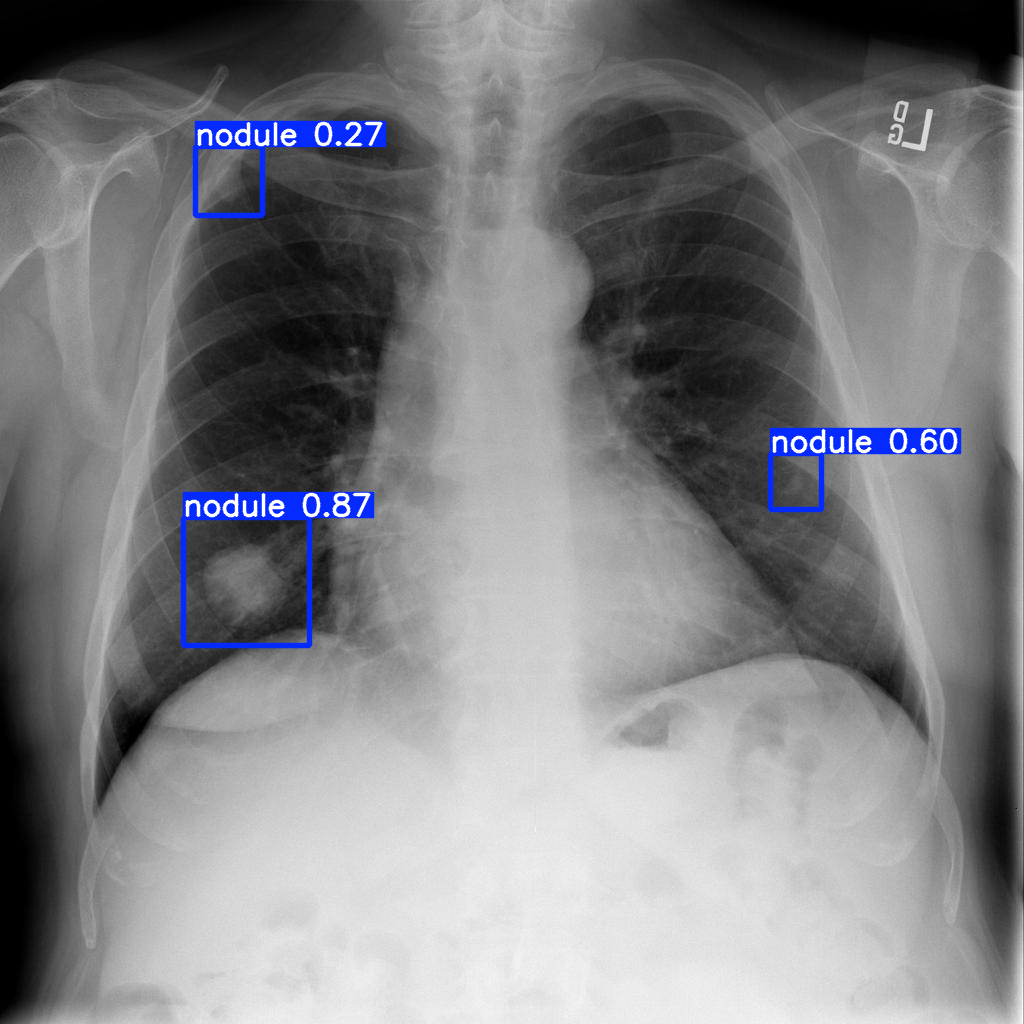

In [13]:
# Example prediction
loaded_model = YOLO("/kaggle/working/best_model.pt")
results = loaded_model("/kaggle/input/pulmonary-nodule-detection/test/jpg/00003751_003.jpg")  # Make predictions on test images

# Show prediction results
for result in results:
    result.show()

### 📂 Final Predictions on Test Data (Export to File)

In [14]:
import os
import json
import pandas as pd
import numpy as np
from PIL import Image

test_images_dir = "/kaggle/input/pulmonary-nodule-detection/test/jpg"
image_files = sorted(os.listdir(test_images_dir))

predictions = []

for img_file in image_files:
    # Full path to the image
    img_path = os.path.join(test_images_dir, img_file)

    # Extract filename without extension, e.g. "00000021_000"
    base_filename = os.path.splitext(img_file)[0]

    # Open image to get width, height, and determine depth
    with Image.open(img_path) as im:
        width, height = im.size
        # Determine the number of channels (depth) based on image mode
        if im.mode == "RGB":
            depth = 3
        elif im.mode == "RGBA":
            depth = 4
        elif im.mode == "L":
            depth = 1
        else:
            depth = 3  # Fallback if mode is unusual

    # Run inference with the loaded YOLO model
    results = loaded_model(img_path)
    result = results[0]

    # Retrieve detection boxes (x1, y1, x2, y2, conf, cls) if present
    if result.boxes is not None and len(result.boxes) > 0:
        boxes = result.boxes.data
        if hasattr(boxes, "cpu"):
            boxes = boxes.cpu().numpy()
        else:
            boxes = np.array(boxes)
    else:
        boxes = np.empty((0, 6))

    objects_list = []
    for box in boxes:
        x1, y1, x2, y2, conf, cls_id = box
        obj_dict = {
            "class": "nodule",
            "bbox": {
                "xmin": int(x1),
                "ymin": int(y1),
                "xmax": int(x2),
                "ymax": int(y2)
            }
        }
        objects_list.append(obj_dict)

    predictions.append({
        "filename": base_filename,
        "width": width,
        "height": height,
        "depth": depth,
        # Convert the list of objects to a JSON string
        "objects": json.dumps(objects_list)
    })

# Create a DataFrame and save to CSV
df = pd.DataFrame(predictions, columns=["filename", "width", "height", "depth", "objects"])
df.to_csv("submission.csv", index=False)
print(f"Created submission.csv with {len(df)} rows.")


image 1/1 /kaggle/input/pulmonary-nodule-detection/test/jpg/00000021_000.jpg: 640x640 1 nodule, 7.4ms
Speed: 3.4ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/pulmonary-nodule-detection/test/jpg/00000093_000.jpg: 640x640 4 nodules, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/pulmonary-nodule-detection/test/jpg/00000105_005.jpg: 640x640 3 nodules, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/pulmonary-nodule-detection/test/jpg/00000199_002.jpg: 640x640 2 nodules, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/pulmonary-nodule-detection/test/jpg/00000199_005.jpg: 640x640 1 nodule, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
